In [1]:
!pip install POT==0.8.2
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 KB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=18dc891475bcd50fdd384993252c31d60bdd3d906dc7a9ca70781bd08ceea7c7
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My \Drive/Colab \Notebooks/Optimal \Transport/Repository


/content/drive/My Drive/Colab Notebooks/Optimal Transport/Repository


In [19]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.autograd import Variable

import wandb
import os

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output

from PIL import Image
from torchvision import models

from tqdm.notebook import tqdm as tqdm
import ot

from networks import resnet_d, conv_icnn32, unet
from networks.resnet_d import weights_init_D

#from losses import VGGPerceptualLoss

from utils import fig2data, fig2img, plot_images

In [5]:
IMG_SIZE = 32 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CHANNELS = 3
BATCH_SIZE = 60000

if CHANNELS == 3:
  TRANSFORM = transforms.Compose([
      transforms.Lambda(lambda x: x.convert('RGB')),
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

if CHANNELS == 1:
  TRANSFORM = transforms.Compose([
      transforms.Resize(IMG_SIZE),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])

# Load train datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
fmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
fmnist_loader = torch.utils.data.DataLoader(fmnist_train, batch_size=BATCH_SIZE, shuffle=True)

# Load test datasets
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
fmnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
fmnist_test_loader = torch.utils.data.DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# We only a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_test_loader))[0]#.squeeze(1).expand(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test_fixed = next(iter(fmnist_test_loader))[0]


del mnist_test_loader, fmnist_test_loader, mnist_test, fmnist_test


/usr/local/lib/python3.8/dist-packages/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


torch.Size([10000, 3072])
torch.Size([3072])


Text(0.5, 1.0, 'EmdTransport')

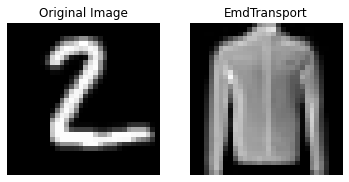

In [6]:

Xs = X_test_fixed.reshape(-1, CHANNELS * IMG_SIZE**2)
Xt = Y_test_fixed.reshape(-1, CHANNELS * IMG_SIZE**2)

ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs[:BATCH_SIZE], Xt=Xt[:BATCH_SIZE])

transp_Xt_emd = ot_emd.transform(Xs=Xs)
print(transp_Xt_emd.shape)
test_idx = 1
print(Xs[test_idx].shape)

if CHANNELS == 3:
  image_original = np.transpose(Xs[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))
  image_transformed = np.transpose(transp_Xt_emd[test_idx].reshape(CHANNELS, IMG_SIZE, IMG_SIZE), (1,2,0))

if CHANNELS == 1:
  image_original = Xs[test_idx].reshape(IMG_SIZE, IMG_SIZE)
  image_transformed = transp_Xt_emd[test_idx].reshape(IMG_SIZE, IMG_SIZE)

plt.subplot(1, 2, 1)
plt.imshow(image_original)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image_transformed)
plt.axis('off')
plt.title('EmdTransport')

torch.Size([9000, 3, 32, 32])
torch.Size([9000, 3, 32, 32])


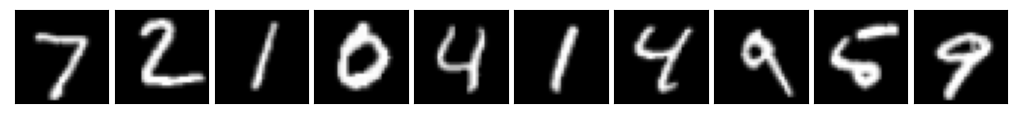

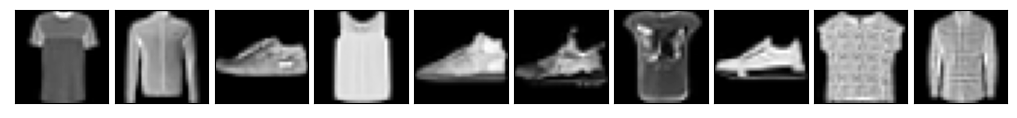

In [9]:
PAIRS_TO_PICK = 9000

X_test_paired = X_test_fixed[:].reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_test_paired = transp_Xt_emd.reshape(-1, 3, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
plot_images(X_test_paired)
plot_images(Y_test_paired)

print(X_test_paired.shape)
print(Y_test_paired.shape)

In [36]:
model_name = 'resnet_d'
CONVEXIFY = False
loss_name = 'l1_loss'

#losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss, 'percep': VGGPerceptualLoss(DEVICE=DEVICE)}
losses = {'l1_loss':F.l1_loss, 'l2_loss':F.mse_loss}



if model_name == 'unet':
    phi = unet.UNet(CHANNELS, 1)
if model_name == 'resnet_d':
    phi = resnet_d.ResNet_D(size=IMG_SIZE)
    phi.apply(weights_init_D)
if model_name == 'conv_icnn':
    phi = conv_icnn32.ConvICNN128(CHANNELS)

phi.to(DEVICE)

criterion = losses[loss_name]

LR = 1e-3
optimizer = torch.optim.Adam(phi.parameters(), lr=LR, betas=(0.8, 0.99))

Epoch: 2990/3000
Training loss:  0.07042635977268219


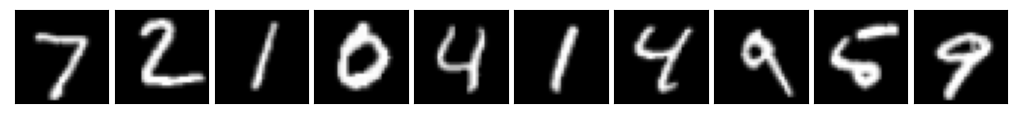

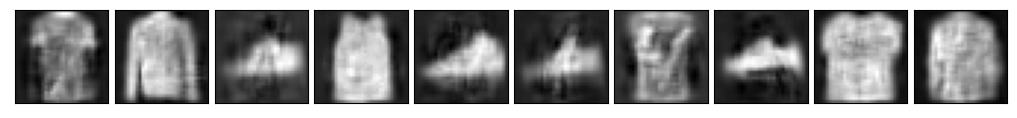

In [37]:
# treat the network as a discriminator that will check if two images are pairs or not.

os.environ["WANDB_API_KEY"] = '449eb3fa3ebc473bba15c04ccfd03a676c074f00'
#os.environ["WANDB_MODE"] = "online"

EPOCHS = 3000

BATCH_SIZE_LOOP = 64
PAIRS_TO_PICK = 128
EPOCH_REPORT = 10

config = {
  "dataset": "MNIST-FMNIST",
  "machine": "Colab",
  "model": model_name,
  "loss_function": loss_name,
  "image_size": IMG_SIZE,
  "learning_rate": LR,
  "batch_size_loop": BATCH_SIZE_LOOP,
  "batch_size_paired": PAIRS_TO_PICK,
  "epochs": EPOCHS
}

if model_name == 'conv_icnn':
  wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"FMNIST-{model_name}-{CONVEXIFY}-{loss_name}", entity="icnn-23", config=config)
else:
  wandb.init(name=f'{loss_name}-{BATCH_SIZE_LOOP}/{PAIRS_TO_PICK}bs',project=f"FMNIST-{model_name}-{loss_name}", entity="icnn-23", config=config)



X_test_paired = X_test_fixed[:].reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]
Y_test_paired = transp_Xt_emd.reshape(-1, CHANNELS, IMG_SIZE, IMG_SIZE)[:PAIRS_TO_PICK]

X = X_test_paired[:]
Y = Y_test_paired[:]

X = Variable(X, requires_grad=True).to(DEVICE)
Y = Variable(Y, requires_grad=True).to(DEVICE)

print(X.shape)
print(Y.shape)

del X_test_paired, Y_test_paired

X_test = X[:10]
X_test = Variable(X_test, requires_grad=True).to(DEVICE)


for epoch in range(EPOCHS):

    permutation = torch.randperm(X.size()[0])

    for i in range(0, X.size()[0], BATCH_SIZE_LOOP):

        indices = permutation[i:i+BATCH_SIZE_LOOP]
        image_x, image_y = X[indices], Y[indices]
        
        if model_name == 'resnet_d':
            out = phi(image_x).squeeze(1)
        else:
            out = phi(image_x)

        if model_name != 'unet':
            out = torch.autograd.grad(out, image_x, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(image_x.size()[0]).cuda().float())[0]

        loss = criterion(out, image_y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if CONVEXIFY and model_name != 'unet':
          phi.convexify()

    if epoch % EPOCH_REPORT == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch}/{EPOCHS}')
        wandb.log({"loss": loss.item()}, step=epoch)
        print('Training loss: ', loss.item())

        if model_name == 'resnet_d':
            out = phi(X_test).squeeze(1)
        else:
            out = phi(X_test)

        if model_name != 'unet':
            out = torch.autograd.grad(out, X_test, create_graph=True, retain_graph=True, only_inputs=True, grad_outputs=torch.ones(X_test.size()[0]).cuda().float())[0]

        fig1 = plot_images(X_test.cpu().detach().numpy(), 10)
        fig2 = plot_images(out.cpu().detach().numpy(), 10)
        wandb.log({'Images' : [wandb.Image(fig2img(fig1)), wandb.Image(fig2img(fig2))]}, step=epoch) 

        #fig2 = plot_images(out.cpu().detach().numpy())
        #wandb.log({'Phi gradient Images' : [wandb.Image(fig2img(fig2))]}, step=epoch) 
        plt.show()
        
        

        